In [115]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [116]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_pan.csv', index_col='CASEID')


In [117]:
data.head()

,PRNCPTX,CPT,CONCPT1,OTHERCPT1,OPERYR,SEX,AGE,HEIGHT,WEIGHT,RACE_NEW,ETHNICITY_HISPANIC,TRANST,WNDCLAS,ASACLAS,DIABETES,SMOKE,DYSPNEA,FNSTATUS2,VENTILAT,HXCOPD,ASCITES,HXCHF,HYPERMED,RENAFAIL,DIALYSIS,STEROID,WTLOSS,BLEEDDIS,TRANSFUS,PRSEPIS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRBILI,PRALKPH,PRWBC,PRHCT,PRPLATE,PRPTT,PRINR,SEPSHOCKPATOS,SSSIPATOS,DSSIPATOS,OSSIPATOS,PNAPATOS,VENTPATOS,UTIPATOS,SEPSISPATOS,OPTIME,PAN_INDICATION,PAN_JAUNDICE,PAN_BILIARYSTENT,PAN_CHEMO,PAN_RADIO,PAN_INTRA_ANTIBIOTICS,PAN_APPROACH,PAN_OINCIS_TYPE,PAN_WOUNDPROT,PAN_DUCTSIZE,PAN_GLANDTEXT,PAN_RECONSTRUCTION,PAN_GASTDUO,PAN_DRAINS,PAN_DRAINS_TYPE,PAN_DRAINSYS_TYPE,PAN_DRAINSYS_SUCTN,PAN_RESECTION,PAN_AMYLASE_POD1,PAN_FISTULA,PAN_NPWT,PAN_TSTAGE,PAN_NSTAGE,PAN_MSTAGE,PAN_BENIGN_TUMORSIZE,BMI
CASEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6522035,0,0,190,467,3,1,-0.666667,1.333333,1.240741,5,0,1,1,2,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,-1.75,-0.571429,-1.071429,-0.857143,0.000000,5.808,0.586207,-0.303030,0.547170,-0.3125,3.0,0,0,0,0,0,0,0,0,1.396970,12,2,1,0,0,1,1,1,2,1,1,2,3,2,5,0,2,1,24.400000,False,2,4,0,0,3,0.497005
6523494,0,0,190,412,3,1,0.666667,0.666667,-0.055556,5,0,1,1,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.00,-0.857143,0.000000,0.285714,1.333333,0.504,-0.206897,0.590909,0.905660,-1.8750,0.3,0,0,0,0,0,0,0,0,0.863636,4,2,0,2,0,0,1,4,2,0,2,2,3,0,5,3,1,1,0.000000,False,2,3,1,0,3,-0.427988
6537888,0,0,190,277,3,0,-0.800000,-0.333333,0.574074,4,2,1,2,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,-0.142857,-0.357143,-0.142857,-0.222222,-0.104,-0.827586,0.196970,0.405660,0.0000,0.0,0,0,0,0,0,0,0,0,1.348485,12,0,0,2,2,0,1,4,2,0,0,2,3,0,5,3,1,1,0.000000,False,2,3,0,0,3,1.057034
6540993,1,1,190,467,3,1,-0.600000,0.500000,0.574074,5,2,1,1,2,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.142857,0.000000,0.428571,0.222222,0.096,0.000000,-0.151515,0.150943,-3.4375,0.0,0,0,0,0,0,0,0,0,1.069697,1,2,1,0,0,1,1,1,2,1,2,2,3,2,5,0,2,1,100.085714,True,2,2,0,0,3,0.382758
6545348,0,0,190,195,3,0,0.266667,-0.500000,-0.351852,5,0,1,1,2,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0.75,-0.285714,-0.428571,-0.714286,-0.222222,-0.272,-1.275862,-0.030303,-0.849057,-2.8125,0.2,0,0,0,0,0,0,0,0,0.821212,12,0,4,2,2,2,1,4,2,0,1,2,3,2,5,0,2,3,18.742857,False,2,3,0,2,3,-0.046548


In [118]:
data.reset_index(inplace=True)
data.drop('CASEID', axis=1, inplace=True)

In [119]:
data.shape

(23233, 76)

In [120]:
y = data['PAN_FISTULA']
X = data.drop(['PAN_FISTULA'], axis=1)

In [121]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [122]:
d = {}
for x in range(0,5):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [123]:
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['PAN_FISTULA'], axis=1))
        dy_train.append(d[x]['PAN_FISTULA'])

In [124]:
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['PAN_FISTULA'], axis=1))
        dy_test.append(d[x]['PAN_FISTULA'])

In [125]:
from tensorflow import keras
input_shape = [X.shape[1]]
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=input_shape))
model4.add(keras.layers.BatchNormalization())
for _ in range(1):
    model4.add(keras.layers.Dense(200))
    model4.add(keras.layers.BatchNormalization())
    model4.add(keras.layers.Dropout(0.8))
    model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=3e-4)

metrics = [keras.metrics.Recall(name='Sensitivity'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.AUC(name='auc'), keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=1e-6,
    restore_best_weights=True,)


In [126]:
#save untrained model
model4.save('model4.h5')

In [127]:
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    model4 = keras.models.load_model('model4.h5')
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/500
28/28 [==============================] - 2s 31ms/step - loss: 1.0218 - Sensitivity: 0.4738 - tn: 5944.0000 - auc: 0.4955 - prc: 0.1663 - val_loss: 0.4472 - val_Sensitivity: 0.0041 - val_tn: 3907.0000 - val_auc: 0.5531 - val_prc: 0.1867
Epoch 2/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8241 - Sensitivity: 0.3819 - tn: 7551.0000 - auc: 0.5249 - prc: 0.1811 - val_loss: 0.4291 - val_Sensitivity: 0.0027 - val_tn: 3913.0000 - val_auc: 0.6124 - val_prc: 0.2269
Epoch 3/500
28/28 [==============================] - 0s 12ms/step - loss: 0.7141 - Sensitivity: 0.2912 - tn: 8788.0000 - auc: 0.5411 - prc: 0.1885 - val_loss: 0.4197 - val_Sensitivity: 0.0041 - val_tn: 3914.0000 - val_auc: 0.6450 - val_prc: 0.2536
Epoch 4/500
28/28 [==============================] - 0s 11ms/step - loss: 0.6618 - Sensitivity: 0.2290 - tn: 9472.0000 - auc: 0.5498 - prc: 0.1923 - val_loss: 0.4138 - val_Sensitivity: 0.0014 - val_tn: 3914.0000 - val_auc: 0.6668 - val_prc: 0.2720
Epoch 5/

In [128]:
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))
ann_score

[0.7252044798685402,
 0.7319904503102976,
 0.72477837735288,
 0.732804192706886,
 0.7270742497806476]

In [129]:
lrpreds = []
model3 = LogisticRegression(penalty='none', warm_start=False)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))
lr_score

C:\Users\KChen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KChen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[0.695504978567075,
 0.699707717536611,
 0.7103089093750568,
 0.7154917622807948,
 0.6956690294429204]

In [130]:
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print('Neural Network:', round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')


Neural Network: 0.728 (0.724-0.733)


In [131]:
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')


Logistic Regression: 0.703 (0.692-0.715)


In [132]:
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')
with open('pan_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.358 (0.34-0.376)
Logistic Regression: 0.319 (0.304-0.334)


In [133]:
for x in range(0,5):
    print(len(annpreds[x]))

4647
4647
4647
4646
4646


pan_ann_tpr = []
pan_ann_fpr = []
for x in range(0,5):
    fpr, tpr, thresholds = roc_curve(dy_test[x], annpreds[x])
    pan_ann_tpr.append(tpr)
    pan_ann_fpr.append(fpr)
pan_ann_tpr_array = [np.array(x) for x in pan_ann_tpr]
mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr_array)]
pan_ann_fpr_array = [np.array(x) for x in pan_ann_fpr]
mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr_array)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr


for x in range(0,5):
    pan_ann_tpr[x] = np.random.permutation(pan_ann_tpr[x])
pan_ann_tpr = [x[:1000] for x in pan_ann_tpr]
for x in range(0,5):
    pan_ann_tpr[x] = sorted(pan_ann_tpr[x])
for x in range(0,5):
    pan_ann_fpr[x] = np.random.permutation(pan_ann_fpr[x])
pan_ann_fpr = [x[:1000] for x in pan_ann_fpr]
for x in range(0,5):
    pan_ann_fpr[x] = sorted(pan_ann_fpr[x])

pan_ann_tpr_array = [np.array(x) for x in pan_ann_tpr]
mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr_array)]
pan_ann_fpr_array = [np.array(x) for x in pan_ann_fpr]
mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr_array)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr

In [134]:
pan_ann_tpr = []
pan_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    pan_ann_tpr.append(tpr)
    pan_ann_fpr.append(fpr)


In [135]:
for x in range(0,5):
    print(len(pan_ann_fpr[x]))
    

1165
1146
1203
1142
1143


In [136]:
for x in range(0,5):
    diff = len(pan_ann_tpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_ann_tpr[x]))
        pan_ann_tpr[x] = np.delete(pan_ann_tpr[x],ind)
for x in range(0,5):
    diff = len(pan_ann_fpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_ann_fpr[x]))
        pan_ann_fpr[x] = np.delete(pan_ann_fpr[x],ind)


mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr)]

mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr

Stored 'mean_pan_ann_tpr' (list)
Stored 'mean_pan_ann_fpr' (list)


In [137]:
pan_lr_tpr = []
pan_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_tpr.append(tpr)
    pan_lr_fpr.append(fpr)


In [138]:
for x in range(0,5):
    print(len(pan_lr_fpr[x]))

1154
1184
1202
1168
1174


In [139]:
for x in range(0,5):
    diff = len(pan_lr_tpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_lr_tpr[x]))
        pan_lr_tpr[x] = np.delete(pan_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(pan_lr_fpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_lr_fpr[x]))
        pan_lr_fpr[x] = np.delete(pan_lr_fpr[x],ind)


mean_pan_lr_tpr = [np.mean(k) for k in zip(*pan_lr_tpr)]

mean_pan_lr_fpr = [np.mean(k) for k in zip(*pan_lr_fpr)]
%store mean_pan_lr_tpr
%store mean_pan_lr_fpr

Stored 'mean_pan_lr_tpr' (list)
Stored 'mean_pan_lr_fpr' (list)


In [140]:
pan_lr_rec = []
pan_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_rec.append(rec)
    pan_lr_prec.append(prec)


In [152]:
for x in range(0,5):
    print(len(pan_lr_rec[x]))

4564
4564
4564
4564
4512


In [153]:

for x in range(0,5):
    diff = len(pan_lr_rec[x]) - 4512
    for _ in range(diff):
        ind = randrange(len(pan_lr_rec[x]))
        pan_lr_rec[x] = np.delete(pan_lr_rec[x],ind)

for x in range(0,5):
    diff = len(pan_lr_prec[x]) - 4512
    for _ in range(diff):
        ind = randrange(len(pan_lr_prec[x]))
        pan_lr_prec[x] = np.delete(pan_lr_prec[x],ind)

mean_pan_lr_rec = [np.mean(k) for k in zip(*pan_lr_rec)]

mean_pan_lr_prec = [np.mean(k) for k in zip(*pan_lr_prec)]
%store mean_pan_lr_rec
%store mean_pan_lr_prec

Stored 'mean_pan_lr_rec' (list)
Stored 'mean_pan_lr_prec' (list)


In [154]:
pan_ann_rec = []
pan_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    pan_ann_rec.append(rec)
    pan_ann_prec.append(prec)


In [155]:
for x in range(0,5):
    print(len(pan_ann_rec[x]))

4644
4622
4607
4644
4647


In [156]:

for x in range(0,5):
    diff = len(pan_ann_rec[x]) - 4600
    for _ in range(diff):
        ind = randrange(len(pan_ann_rec[x]))
        pan_ann_rec[x] = np.delete(pan_ann_rec[x],ind)

for x in range(0,5):
    diff = len(pan_ann_prec[x]) - 4600
    for _ in range(diff):
        ind = randrange(len(pan_ann_prec[x]))
        pan_ann_prec[x] = np.delete(pan_ann_prec[x],ind)

mean_pan_ann_rec = [np.mean(k) for k in zip(*pan_ann_rec)]

mean_pan_ann_prec = [np.mean(k) for k in zip(*pan_ann_prec)]
%store mean_pan_ann_rec
%store mean_pan_ann_prec

Stored 'mean_pan_ann_rec' (list)
Stored 'mean_pan_ann_prec' (list)


pan_lr_rec = []
pan_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_rec.append(rec)
    pan_lr_prec.append(prec)

for x in range(0,5):
    pan_lr_rec[x] = np.random.permutation(pan_lr_rec[x])
pan_lr_rec = [x[:1000] for x in pan_lr_rec]
for x in range(0,5):
    pan_lr_rec[x] = sorted(pan_lr_rec[x])
for x in range(0,5):
    pan_lr_prec[x] = np.random.permutation(pan_lr_prec[x])
pan_lr_prec = [x[:1000] for x in pan_lr_prec]
for x in range(0,5):
    pan_lr_prec[x] = sorted(pan_lr_prec[x])
pan_lr_rec_array = [np.array(x) for x in pan_lr_rec]
mean_pan_lr_rec = [np.mean(k) for k in zip(*pan_lr_rec_array)]
pan_lr_prec_array = [np.array(x) for x in pan_lr_prec]
mean_pan_lr_prec = [np.mean(k) for k in zip(*pan_lr_prec_array)]
%store mean_pan_lr_rec
%store mean_pan_lr_prec

from matplotlib import pyplot as plt

plt.plot(mean_pan_ann_rec, mean_pan_ann_prec)

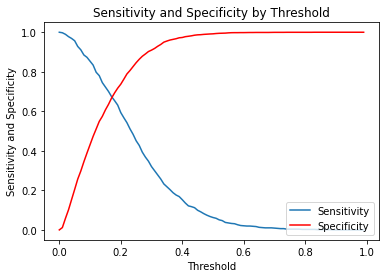

In [157]:
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
annrecall_list = []
for i in thresh:
    annrecall_list.append(recall_score(dy_test[1], annpreds[1] > i))
#calculate spec at 10 thresholds
annspec_list = []
for i in thresh:
    annspec_list.append(specificity_score(dy_test[1], annpreds[1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, annrecall_list, label = 'Sensitivity')
plt.plot(thresh, annspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()

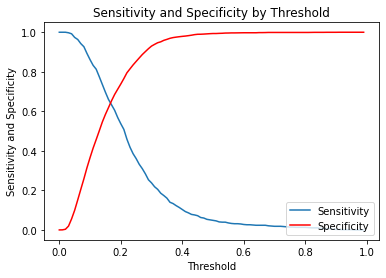

In [158]:
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
lrrecall_list = []
for i in thresh:
    lrrecall_list.append(recall_score(dy_test[1], lrpreds[1][:,1] > i))
#calculate spec at 10 thresholds
lrspec_list = []
for i in thresh:
    lrspec_list.append(specificity_score(dy_test[1], lrpreds[1][:,1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, lrrecall_list, label = 'Sensitivity')
plt.plot(thresh, lrspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()

In [159]:
print(recall_score(dy_test[1], lrpreds[1][:,1] > 0.15))
print(specificity_score(dy_test[1], lrpreds[1][:,1] > 0.15))

0.6967320261437908
0.5842349304482226


In [160]:
print(recall_score(dy_test[1], annpreds[1] > 0.3))
print(specificity_score(dy_test[1], annpreds[1] > 0.3))

0.3202614379084967
0.9095826893353941


In [161]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


p = []
z = []
# Model A (random) vs. "good" model B
for x in range(0,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))
    p.append(st.norm.sf(abs(z[x-1]))*2)


for x in range(0,5):
    print(p[x])

1.8767393285809614e-08
1.8767393285809614e-08
9.134079483989441e-09
0.005724029557307809
0.0031678343144419924


In [162]:
sum(p)/(len(p))

0.0017783821081231715